# Asyncio

El módulo asyncio proporciona herramientas para construir aplicaciones concurrentes que utilizan co-rutinas.

Recordando el módulo *threading* implementa concurrencia a través de hilos de aplicación, por el otro lado *multiprocessing* implementa la concurrencia usando procesos del sistema. *Asyncio* utiliza un enfoque de un solo hilo y un solo proceso que están dentro de una aplicación, en algún momento estos procesos necesitan leer o escribir datos, y que bloquearían a la aplicación si no se utiliza Asyncio. *Asyncio* también permite crear:

* programas que se ejecuten en un futuro específico
* brinda la posiblidad de que una co-rutina se ejecute después de otra
* manejar señales del sistema
* reconocer otros eventos.

La mayoría de los programas que usan otros modelos de concurrencia, se escriben de manera lineal y se deja la gestión de los procesos y el tiempo de ejecución al lenguaje de programación o al sistema operativo. `Asyncio` requiere que el código de la aplicación maneje explicitamente los cambios de contexto.

`Asyncio` brinda un bucle de eventos, para registrar la pieza del código a  ejecutar. Por ejemplo, un servidor en red abre los conectores y luego los registra para recibir avisos cuando eventos ocurren en ellos. El bucle de eventos alerta al código del servidor cuando hay una nueva conexión entrante o cuando hay datos para leer. Se espera que el código de la aplicación ceda el control nuevamente después de un corto período de tiempo cuando no se puede hacer más trabajo en el contexto actual. Por ejemplo, si no hay más datos para leer desde un conector el servidor debe devolver el control al bucle de eventos.

Un **Futuro** es una estructura de datos que representa el resultado del trabajo que aún no se ha completado. El bucle de eventos puede esperar que un objeto *Future* se configure como hecho, permitiendo que una parte de una aplicación esperar a que otra parte termine un trabajo.

Una **Task** es una subclase de Future que sabe cómo envolver y gestionar la ejecución de una co-rutina. Las tareas pueden ser programadas con el bucle de eventos para ejecutarse cuando los recursos que necesitan estén disponibles, y para producir un resultado que pueda ser consumido por otras co-rutinas.



## Awaitable
Decimos que es un objeto "esperable" o awaitable si se puede utilizar la expresión `await`.
Hay tres objetos esperables: corrutinas, tareas, y futuros.

## co-rutinas

In [9]:
import asyncio

async def main():
    print('Hello ...')
    await asyncio.sleep(1)
    print('... World!')

# asyncio.run(main())
main()

<coroutine object main at 0x7fad903334c0>

Tenemos 3 formas para ejecutar una corrutina, asyncio proporciona tres mecanismos principales:

* La función asyncio.run() para ejecutar la función de un punto de entrada de nivel superior "main()".
* Esperando en una corrutina. 

In [6]:
import asyncio
import time

async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

async def main():
    print(f"started at {time.strftime('%X')}")

    await say_after(1, 'hello')
    await say_after(2, 'world')

    print(f"finished at {time.strftime('%X')}")

# asyncio.run(main())

## Tasks
La función `asyncio.create_task()` para ejecutar corrutinas concurrentemente como asyncio Tasks. Si name no es `None`, se establece como el nombre de la tarea mediante Task.set_name().

La tarea se ejecuta en el bucle retornado por get_running_loop(), `RuntimeError` se genera si no hay ningún bucle en ejecución en el subproceso actual.

In [7]:
async def main():
    task1 = asyncio.create_task(
        say_after(1, 'hello'))

    task2 = asyncio.create_task(
        say_after(2, 'world'))

    print(f"started at {time.strftime('%X')}")

    await task1
    await task2

    print(f"finished at {time.strftime('%X')}")

# asyncio.run(main())

In [2]:
import asyncio

async def cancel_me():
    print('cancel_me(): before sleep')

    try:
        # Wait for 1 hour
        await asyncio.sleep(3600)
    except asyncio.CancelledError:
        print('cancel_me(): cancel sleep')
        raise
    finally:
        print('cancel_me(): after sleep')

async def main():
    # Create a "cancel_me" Task
    task = asyncio.create_task(cancel_me())

    # Wait for 1 second
    await asyncio.sleep(1)

    task.cancel()
    try:
        await task
    except asyncio.CancelledError:
        print("main(): cancel_me is cancelled now")

# asyncio.run(main())

## Futures

Un Future es un objeto esperable especial de bajo-nivel que representa un resultado eventual de una operación asíncrona.

Cuando un objeto Future es esperado significa que la corrutina esperará hasta que el Future se resuelva en algún otro lugar.

Los objetos Future de asyncio son necesarios para permitir que el código basado en retro llamada se use con async/await.

Normalmente, no es necesario crear objetos Future en el código de nivel de aplicación.

Los objetos Future, a veces expuestos por bibliotecas y algunas API de asyncio, pueden ser esperados.

In [10]:
async def main():
    await function_that_returns_a_future_object()

    # this is also valid:
    await asyncio.gather(
        function_that_returns_a_future_object(),
        some_python_coroutine()
    )

## Sleep

Bloquea por *delay* segundos.

`sleep()` siempre suspende la tarea actual, permitiendo que se ejecuten otras tareas.


In [11]:
import asyncio
import datetime

async def display_date():
    loop = asyncio.get_running_loop()
    end_time = loop.time() + 5.0
    while True:
        print(datetime.datetime.now())
        if (loop.time() + 1.0) >= end_time:
            break
        await asyncio.sleep(1)

# asyncio.run(display_date())


# Ejecutando tareas concurrentemente
Esto se realiza utilizando `asyncio.gather(*aws, loop=None, return_exceptions=False)` Cuando todos los awaitables o esperables se completan, el resultado es una lista de valores retornados por las tareas.

*aws* es una corrutina.

Si *return_exceptions* es False (valor predeterminado), la primera excepción provocada se propaga inmediatamente a la tarea que espera en gather(). Otros esperables en la secuencia aws no se cancelarán y continuarán ejecutándose.

Si *return_exceptions* es True, las excepciones se tratan igual que los resultados correctos y se agregan en la lista de resultados.

Si gather() es cancelado, todos los esperables enviados (que aún no se han completado) también se cancelan.

In [12]:
import asyncio

async def factorial(name, number):
    f = 1
    for i in range(2, number + 1):
        print(f"Task {name}: Compute factorial({i})...")
        await asyncio.sleep(1)
        f *= i
    print(f"Task {name}: factorial({number}) = {f}")

async def main():
    # Schedule three calls *concurrently*:
    await asyncio.gather(
        factorial("A", 2),
        factorial("B", 3),
        factorial("C", 4),
    )

# asyncio.run(main())

# wait_for

`asyncio.wait_for(aw, timeout, *, loop=None)` se utiliza para darle un "tiempo" para que se ejecute la corrutina.

*timeout* puede ser None o punto flotante o un número entero de segundos a esperar. Si *timeout* es None, se bloquea hasta que futuro se complete.

Si se produce un agotamiento de tiempo, cancela la tarea y genera `asyncio.TimeoutError`.

Para evitar la cancelación de la tarea se la puede envolver en un `shield()`.

In [14]:
async def eternity():
    # Sleep for one hour
    await asyncio.sleep(3600)
    print('yay!')

async def main():
    # Wait for at most 1 second
    try:
        await asyncio.wait_for(eternity(), timeout=1.0)
    except asyncio.TimeoutError:
        print('timeout!')

# asyncio.run(main())


# wait
Para ejecutar objetos awaitables (*aws*) y bloquea hasta que la condición especifiacada en el *return_when* `coroutine asyncio.wait(aws, *, loop=None, timeout=None, return_when=ALL_COMPLETED)`.

`wait()` retorna dos conjuntos  de tareas/futuros `(done, pending)`

```
done, pending = await asyncio.wait(aws)
```

Tenga en cuenta que esta función no lanza `asyncio.TimeoutError`. Los Futuros o Tareas que no terminan cuando se agota el tiempo simplemente se retornan en el segundo conjunto.

A diferencia de wait_for(), wait() no cancela los Futuros cuando se produce un agotamiento de tiempo.


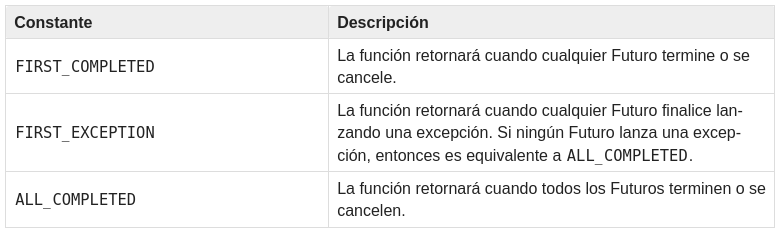